In [2]:
import json
import pandas as pd
from twitter import *
from numpy import random
import json

import tweepy
from tweepy import OAuthHandler
from tweepy import Cursor
import os
import json
import pandas as pd

In [1]:
!pip install twitter

     |████████████████████████████████| 61kB 4.7MB/s 


In [3]:
#Collect Data 
#Variables that contains the user credentials to access Twitter API
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [4]:
def getUserAttributes(screen_name):
    user = api.get_user(screen_name)
    print("Screen name: ", user.screen_name)
    print("Number of Followers: ", user.followers_count)
    print("Number of Friends: ", user.friends_count)
getUserAttributes("UnderArmour")

Screen name:  UnderArmour
Number of Followers:  950642
Number of Friends:  877


In [5]:
def getUserProfiles(screen_name):
    dirname = "output/users/{}".format(screen_name)
    os.makedirs(dirname, mode=0o755, exist_ok=True)
    print("collecting data for " + screen_name)
    fname = "output/users/{}/user_profile.json".format(screen_name)
    print("Collecting profile information for", screen_name)
    with open(fname, 'a+') as f:
        profile = api.get_user(screen_name=screen_name)        
        f.write(json.dumps(profile._json, indent=3))   
    print("User Profile collected")

getUserProfiles("UnderArmour")

collecting data for UnderArmour
User Profile collected


In [6]:
def paginate(items, n):
    for i in range(0, len(items), n):
        yield items[i:i+n]

In [7]:
def getFollowers(screen_name):
    fname = "output/users/{}/followers.json".format(screen_name)
    print("Collecting followers for ", screen_name)
    with open(fname, 'w') as f:
        for followers in Cursor(api.followers_ids, screen_name=screen_name, count=50).pages(2):
            for page in paginate(followers, 100):
                users = api.lookup_users(user_ids=page)
                for user in users:  
                    #print(user.screen_name)
                    f.write(json.dumps(user._json)+"\n")
    print("Followers collected")   
getFollowers("UnderArmour")

Followers collected


In [8]:
def getFriends(screen_name):
    fname = "output/users/{}/friends.json".format(screen_name)
    print("Collecting friends for ", screen_name)
    with open(fname, 'w') as f:
        for friends in Cursor(api.friends_ids, screen_name=screen_name, count=50).pages(2):
            for page in paginate(friends, 100):
                users = api.lookup_users(user_ids=page)
                for user in users:
                    f.write(json.dumps(user._json)+"\n")
    print("Friends collected")  
getFriends("UnderArmour")

Friends collected


In [ ]:
#Start scraping based on the followers and friends ID
# Loading my authentication tokens
with open('secrets.json','r') as f:
    twtr_auth = json.load(f)

t = Twitter(auth=OAuth(twtr_auth['ACCESS_TOKEN_KEY'], twtr_auth['ACCESS_TOKEN_SECRET'], 
            twtr_auth['CONSUMER_KEY'], twtr_auth['CONSUMER_SECRET']))

In [9]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [11]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=1000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=1000)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


In [12]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
        "Must have screen_names or user_ids, but not both"
    items_to_info = {}
    items = screen_names or user_ids
    sorted_by_follow_count = []
    while len(items) > 0:
        # Process 100 items at a time per the API specifications for /users/lookup.
        # See https://dev.twitter.com/docs/api/1.1/get/users/lookup for details.
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, user_id=items_str)
        for user_info in response:
            if screen_names:
                items_to_info[user_info['followers_count']] = user_info['screen_name']
            else: # user_ids
                items_to_info[user_info['followers_count']] = user_info['id']
        #print("RESPONCE", response)
        #print("DISCTIONAY", items_to_info)
    for key in sorted(items_to_info, reverse=True):
        sorted_by_follow_count.append(items_to_info[key])
    return sorted_by_follow_count[:5]

In [ ]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['ID','ReciprocalFriend'])
df.to_csv('ReciprocalFriend.csv', index=False)

# Our function
def save_followers(fid, reciprocal_friend):
    data_frame_rf = [[str(fid), str(i)] for i in reciprocal_friend]
    #print(data_frame_rf)
    df = pd.DataFrame(data_frame_rf, columns=['ID','ReciprocalFriend'])
    with open('ReciprocalFriend.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [13]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=seed_id,
                                 friends_limit=limit, followers_limit=limit)
    rp_friend = list(set(friends_ids) & set(followers_ids))
    top_five = get_user_profile(t, user_ids=rp_friend[:100])
    next_queue = top_five
    # Store a seed_id => _follower_ids mapping in MongoDB
    
    save_followers(seed_id, next_queue)
    
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth:
        print("Number of ", d,"- Distance node", len(next_queue))
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
            friends_ids, followers_ids = get_friends_followers_ids(twitter_api, user_id=fid,
                                friends_limit=limit, followers_limit=limit)
            # Store an ID with a string recording
            # IDs of followers of the user with ID "fid"
            rp_friend = list(set(friends_ids) & set(followers_ids))
            if (len(rp_friend) == 0):
                continue
            top_five = get_user_profile(t, user_ids=rp_friend[-100:])
            save_followers(str(fid), top_five)
            # Extending the list
            next_queue += top_five

In [16]:
screen_name = "UnderArmour"
friends_file = 'friends.json'.format(screen_name)
followers_file = 'followers.json'.format(screen_name)
users = []
with open(friends_file) as f:
    for line in f:
        profile = json.loads(line)
        users.append(profile['screen_name'])
with open(followers_file) as f:
    for line in f:
        profile = json.loads(line)
        users.append(profile['screen_name'])
print(len(users))

1877


In [ ]:
for name in users:
    crawl_followers(t, name, depth=4, limit=1000)

In [17]:
#Read the data from the file 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [18]:
# Create Graph from file
df = pd.read_csv("ReciprocalFriendUnderArmour.csv")

In [19]:
df = df.dropna()
df = df.applymap(int)

In [20]:
x_point = list(df[df.columns[0]].values)
y_point = list(df[df.columns[1]].values)
edges_list = []
for i in range(len(x_point)):
    edges_list.append((x_point[i], y_point[i]))
node_list = set(x_point+y_point)
RG = nx.Graph()
RG.add_nodes_from(node_list)
RG.add_edges_from(edges_list)

In [21]:
# Display some graph information such as number of nodes and edges
print ("Number of Nodes :", RG.number_of_nodes())
print ("Numebr of edges :", RG.number_of_edges())

Number of Nodes : 2433
Numebr of edges : 2111


In [22]:
# Calculate network density
# It shows how the connected nodes to each others.
print("Network Density", nx.density(RG))

Network Density 0.0007135305124710666


In [23]:
print(nx.is_connected(RG))
components = nx.connected_components(RG)
largestSubgraph = max(components, key=len)
print(largestSubgraph)
print(len(largestSubgraph))

False
{1362844032490160128, 1231762607608150016, 1128302811698089984, 726629265098285056, 136036360, 43192340, 1136574486, 601407511, 39104537, 15233063, 318668840, 15984698, 419328059, 56287290, 444059710, 15220806, 588056646, 307152971, 163379277, 2275233870, 26548315, 81934431, 236515427, 459882609, 19066998, 143157367, 37599351, 234252414, 1311322242, 106209417, 818014362, 263723174, 31174833, 319805618, 170164405, 69750965, 1377224900, 161409221, 57893062, 212629710, 3683217617, 267251926, 277541083, 19382500, 813286, 283740396, 262355181, 80107770, 1545931003, 468445437, 1365817895469639936, 1006802766906439936, 43698434, 1358136287383970048, 2884540679, 48460039, 306200842, 849328400, 53553429, 109383957, 79896855, 55015704, 240701725, 57411871, 19734817, 3501625637, 2765267240, 2765267241, 210684204, 210684205, 3171670319, 38580532, 15397175, 40519997, 282814783, 16879936, 3100784961, 18917699, 2905108806, 7098702, 115286354, 16423253, 38662490, 2168932705, 487706984, 46705002,

In [24]:
components = nx.connected_components(RG)

In [25]:
#Need to rerun the component 
minSubgraph = min(components, key=len)
print('len:',len(minSubgraph))
#print(min_subgraph)

len: 2


In [26]:
person_dict = dict(RG.degree(RG.nodes))
#person_dict
nx.set_node_attributes(RG, name="degree", values=person_dict)

In [27]:
for i in nx.degree(RG):
  if i[1] == 1:
    print(i[0],i[1])

1137797315224150016 1
1117716271766700032 1
28663822 1
1136574486 1
743538714 1
90570779 1
318668840 1
787152938 1
2544328748 1
112541740 1
1965056058 1
56287290 1
35274814 1
3124379711 1
35274815 1
2863759427 1
49700935 1
580591686 1
284188758 1
625991767 1
419078233 1
360366171 1
2644680802 1
2694414438 1
17547367 1
59572333 1
459882609 1
1143201913 1
308379771 1
879295699829042944 1
849093658943074048 1
1132464185005219968 1
349151372 1
349151373 1
1102078094 1
1022419093 1
2525470875 1
40886429 1
481910949 1
13213862 1
35733687 1
15614141 1
65544386 1
136061123 1
133726414 1
2999959761 1
47956182 1
1859207384 1
240025823 1
32743648 1
19382500 1
19382501 1
479928570 1
1050231340573090048 1
1294058349873570048 1
1360217874015650048 1
1099493336669430016 1
1365734400391069952 1
1245293358538309888 1
306200842 1
2232770828 1
56443153 1
39706897 1
302268692 1
79896855 1
216998174 1
577552672 1
19734817 1
195887396 1
2765267240 1
2765267241 1
2207973674 1
31949107 1
115040577 1
39592258 

In [28]:
from operator import itemgetter

In [29]:
# Sort the degrees of nodes
sortedDegrees = sorted(person_dict.items(), key=itemgetter(1), reverse=True)
#sortedDegrees = sorted(person_dict.items(), key=itemgetter(1), reverse=False)

#print(sortedDegrees)

for p in sortedDegrees[:20]:
  print(p)

(23114836, 35)
(876249583340456960, 10)
(712897952, 8)
(312745095, 8)
(210684204, 7)
(178840688, 6)
(199763486, 6)
(1194992333676300032, 6)
(1267771692, 6)
(22686121, 6)
(55298784, 6)
(27667866, 6)
(265522709, 6)
(1209192698, 6)
(505934719, 6)
(527694278, 6)
(19733898, 6)
(31161814, 6)
(1214671202205270016, 5)
(1354212570056450048, 5)


In [30]:
# Calculate node betweenness and eigenvector
betweenness_dict = nx.betweenness_centrality(RG)
eigen_dict = nx.eigenvector_centrality(RG, max_iter=200)
closeness_dict = nx.closeness_centrality(RG)

nx.set_node_attributes(RG, name="betweenness", values="betweenness_dict")
nx.set_node_attributes(RG, name="eigenvector", values="eigen_dict")
nx.set_node_attributes(RG, name="closenessvector", values="closeness_dict")

In [31]:
# Sort nodes by key/values e.g. betweenness
sortedBetweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by betweenness centrality:")
for p in sortedBetweenness[:10]:
  print(p)

Top 10 nodes by betweenness centrality:
(23114836, 0.028539639540026522)
(312745095, 0.017841460977103388)
(22451734, 0.013361928319358665)
(319805618, 0.006338427439433632)
(219823828, 0.006308094640137984)
(1170075758913600000, 0.0054527999090692595)
(2508496374, 0.005426848693102563)
(602188858, 0.005118237026131763)
(22686121, 0.0049630210475798695)
(505934719, 0.004320563337591202)


In [32]:
sortedEigen = sorted(eigen_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by eigen centrality:")
for p in sortedEigen[:10]:
  print(p)

Top 10 nodes by eigen centrality:
(23114836, 0.6543237813829593)
(859106874, 0.13654867883027033)
(818014362, 0.13299436530473563)
(412323221, 0.12981912200689943)
(523917886, 0.12981912200689943)
(190762445, 0.1298191220068994)
(170164405, 0.12772218247927303)
(1545931003, 0.12747762753202996)
(1585374968, 0.12456760774073788)
(930989796, 0.12425166466015476)


In [33]:
sortedCloseness = sorted(closeness_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by closeness centrality:")
for p in sortedCloseness[:10]:
  print(p)

Top 10 nodes by closeness centrality:
(23114836, 0.04767179449773704)
(22451734, 0.044138782186437554)
(312745095, 0.04199387709686317)
(319805618, 0.03965143860832919)
(2508496374, 0.0396157968657599)
(859106874, 0.03929788142055987)
(818014362, 0.0392628721720783)
(412323221, 0.0392628721720783)
(190762445, 0.0392628721720783)
(523917886, 0.0392628721720783)


In [34]:
#First get the top ??? nodes by betweenness as a list
topBetweenness = sortedBetweenness[:10]

#Then find and print their degree
for p in topBetweenness:
  print("Name: ",p[0], "Degree: ", person_dict[p[0]],"Betweenness: ",p[1])

Name:  23114836 Degree:  35 Betweenness:  0.028539639540026522
Name:  312745095 Degree:  8 Betweenness:  0.017841460977103388
Name:  22451734 Degree:  5 Betweenness:  0.013361928319358665
Name:  319805618 Degree:  5 Betweenness:  0.006338427439433632
Name:  219823828 Degree:  5 Betweenness:  0.006308094640137984
Name:  1170075758913600000 Degree:  5 Betweenness:  0.0054527999090692595
Name:  2508496374 Degree:  5 Betweenness:  0.005426848693102563
Name:  602188858 Degree:  3 Betweenness:  0.005118237026131763
Name:  22686121 Degree:  6 Betweenness:  0.0049630210475798695
Name:  505934719 Degree:  6 Betweenness:  0.004320563337591202


In [35]:
topEigen = sortedEigen[:10]

#Then find and print their degree
for p in topEigen:
  print("Name: ",p[0], "Degree: ", person_dict[p[0]],"Eigen: ",p[1])

Name:  23114836 Degree:  35 Eigen:  0.6543237813829593
Name:  859106874 Degree:  5 Eigen:  0.13654867883027033
Name:  818014362 Degree:  5 Eigen:  0.13299436530473563
Name:  412323221 Degree:  5 Eigen:  0.12981912200689943
Name:  523917886 Degree:  5 Eigen:  0.12981912200689943
Name:  190762445 Degree:  5 Eigen:  0.1298191220068994
Name:  170164405 Degree:  5 Eigen:  0.12772218247927303
Name:  1545931003 Degree:  5 Eigen:  0.12747762753202996
Name:  1585374968 Degree:  5 Eigen:  0.12456760774073788
Name:  930989796 Degree:  5 Eigen:  0.12425166466015476


In [36]:
topCloseness = sortedCloseness[:10]

#Then find and print their degree
for p in topCloseness:
  print("Name: ",p[0], "Degree: ", person_dict[p[0]],"Closeness: ",p[1])

Name:  23114836 Degree:  35 Closeness:  0.04767179449773704
Name:  22451734 Degree:  5 Closeness:  0.044138782186437554
Name:  312745095 Degree:  8 Closeness:  0.04199387709686317
Name:  319805618 Degree:  5 Closeness:  0.03965143860832919
Name:  2508496374 Degree:  5 Closeness:  0.0396157968657599
Name:  859106874 Degree:  5 Closeness:  0.03929788142055987
Name:  818014362 Degree:  5 Closeness:  0.0392628721720783
Name:  412323221 Degree:  5 Closeness:  0.0392628721720783
Name:  190762445 Degree:  5 Closeness:  0.0392628721720783
Name:  523917886 Degree:  5 Closeness:  0.0392628721720783


In [37]:
import community
import matplotlib.pyplot as plt
import networkx as nx

#community API
#https://perso.crans.org/aynaud/communities/api.html

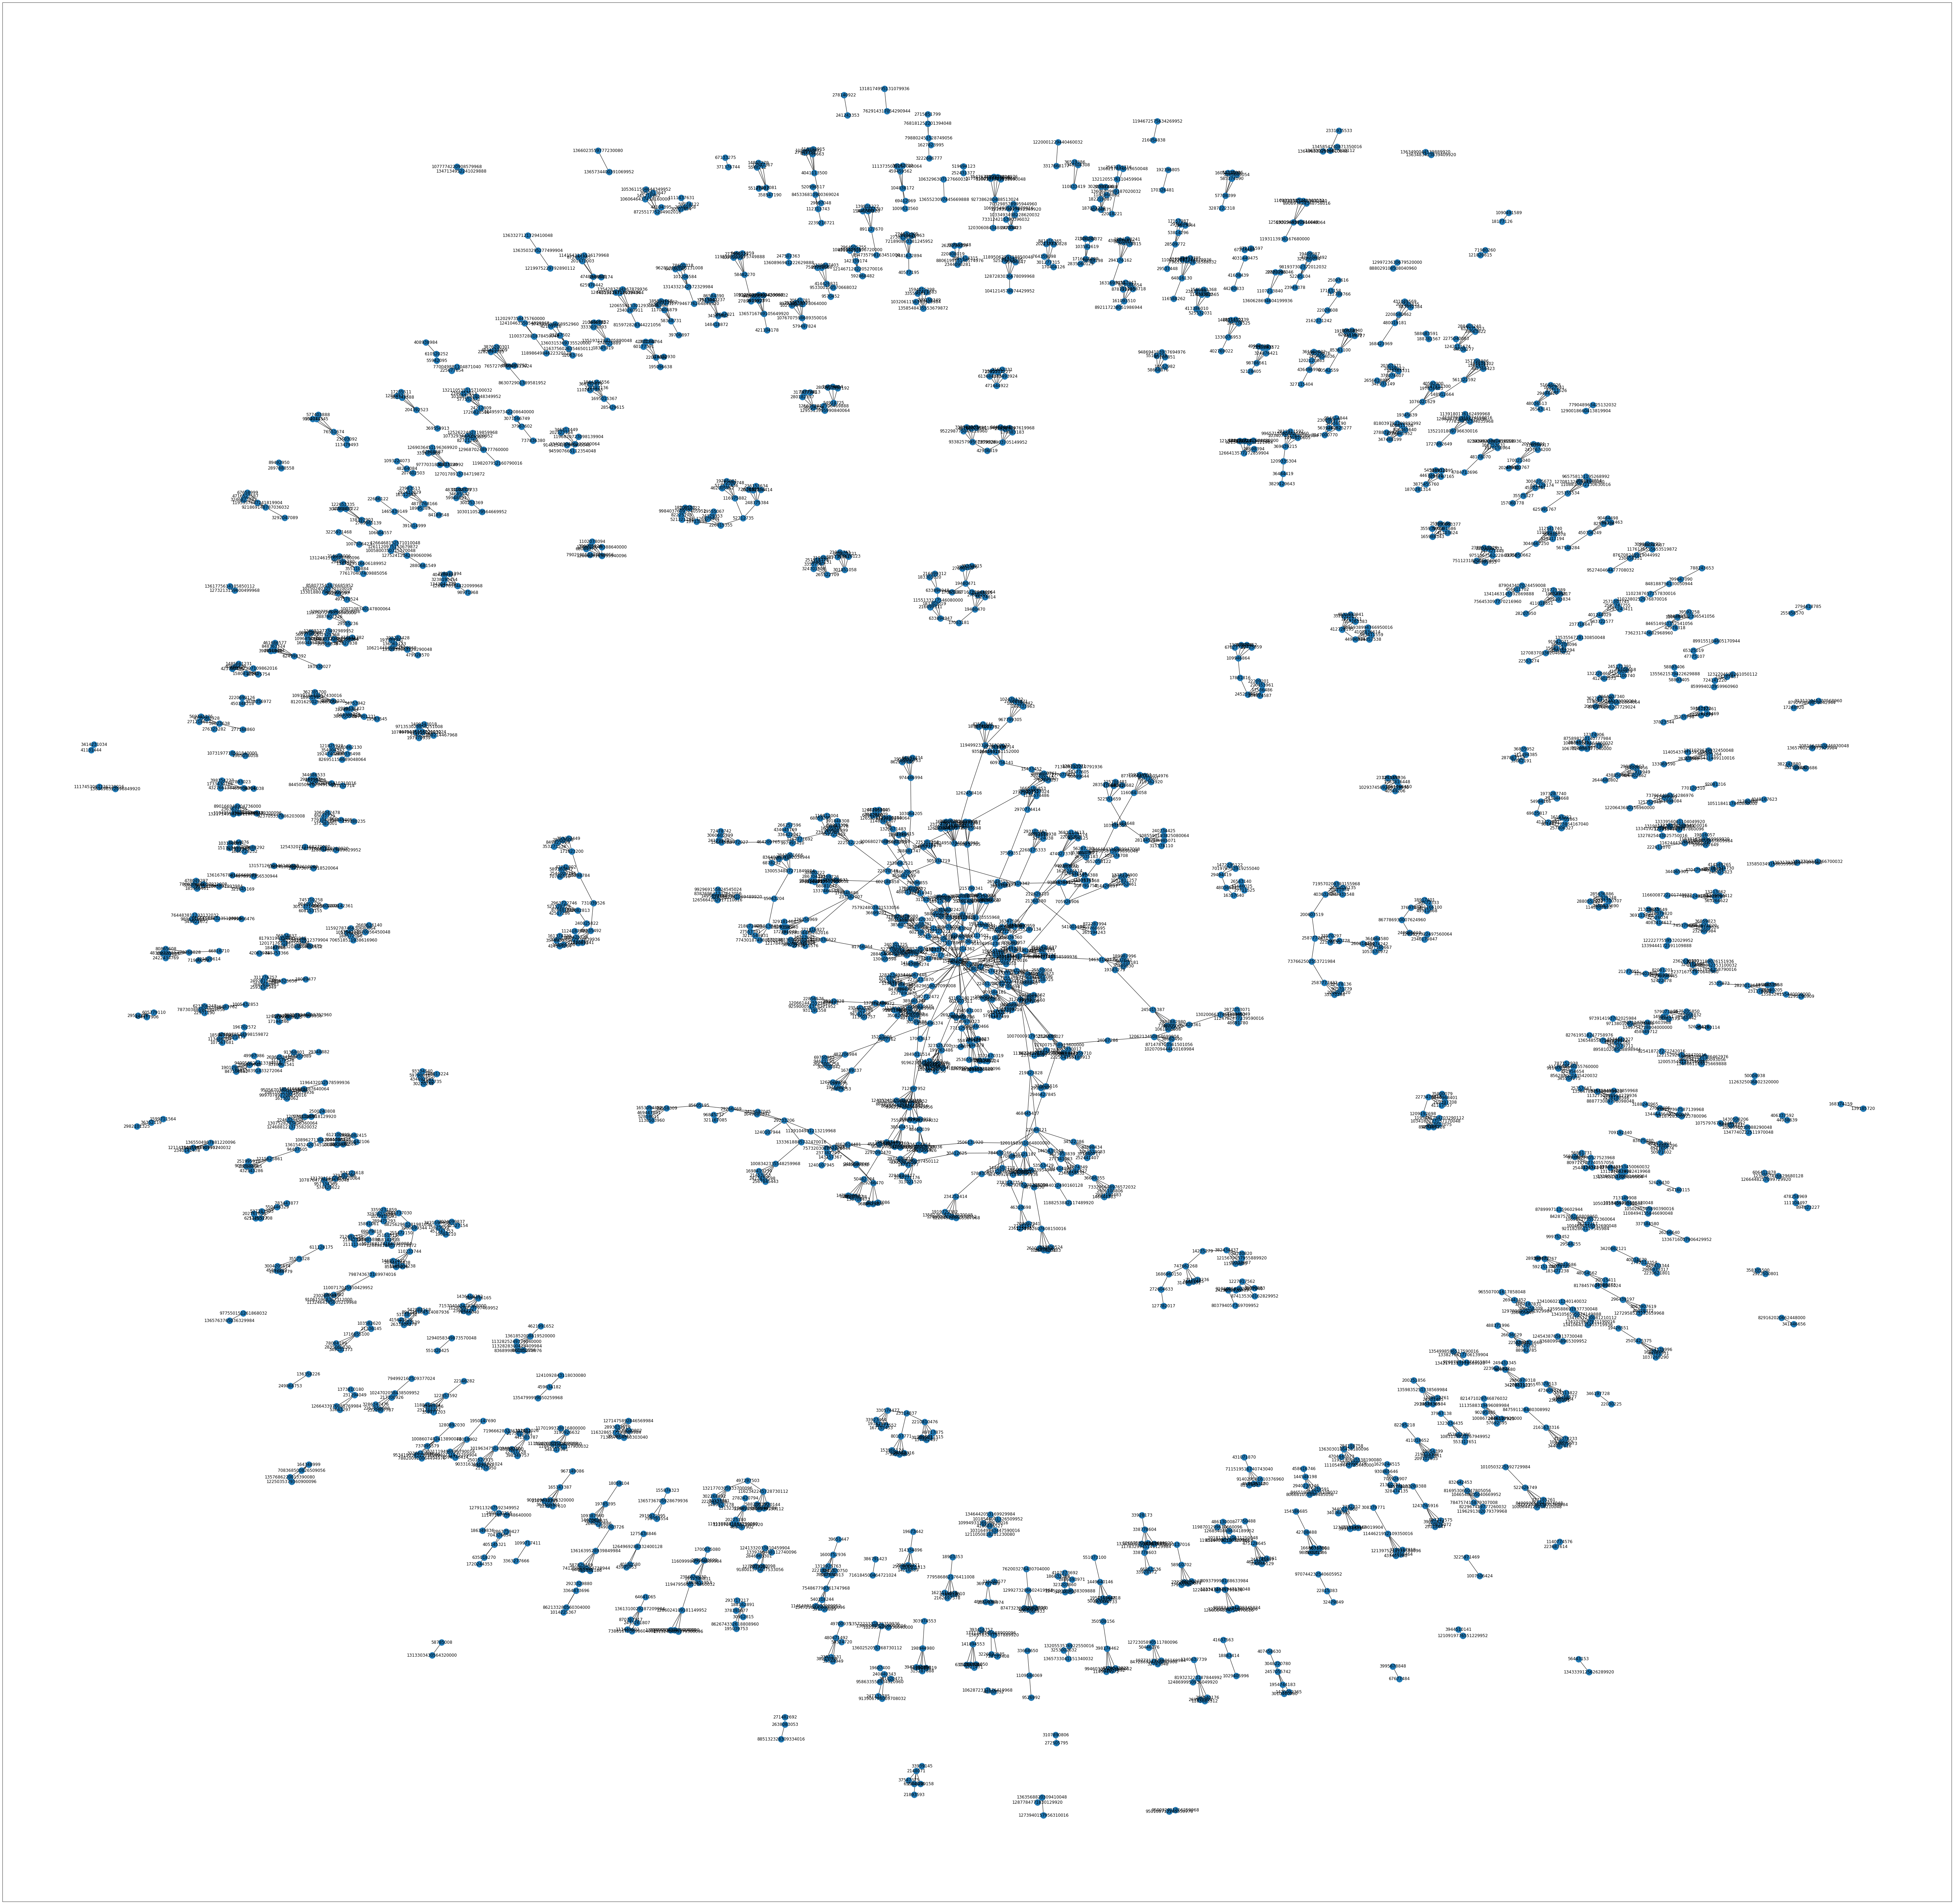

In [38]:
plt.figure(figsize=(100,100))
#nx.draw_networkx(G, pos=nx.circular_layout(G))
nx.draw_networkx(RG, pos=nx.spring_layout(RG))
plt.show()

#nx.write_gexf(RG, 'UnderArmour.gexf')

In [39]:
partition = community.best_partition(RG)
print(partition)

{1214671202205270016: 0, 1354212570056450048: 1, 1289270314422099968: 2, 1365504967881220096: 3, 1300534887271849984: 4, 765727678666113024: 5, 1362844032490160128: 6, 1137797315224150016: 7, 136036360: 79, 1283910241118289920: 9, 1117716271766700032: 10, 28663822: 11, 1136574486: 12, 601407511: 13, 90570778: 14, 743538714: 15, 90570779: 14, 318668840: 12, 787152938: 16, 2544328748: 17, 112541740: 18, 1965056058: 19, 56287290: 20, 35274814: 21, 3124379711: 22, 35274815: 21, 2863759427: 23, 15220806: 24, 49700935: 25, 580591686: 26, 606412878: 27, 284188758: 28, 625991767: 29, 419078233: 30, 248086619: 31, 360366171: 32, 2644680802: 33, 2694414438: 34, 17547367: 35, 59572333: 31, 459882609: 12, 1143201913: 36, 933825799567879936: 37, 914549942387126016: 20, 308379771: 39, 879295699829042944: 40, 849093658943074048: 41, 1132464185005219968: 42, 301277315: 43, 106209417: 12, 349151372: 44, 349151373: 45, 29556878: 46, 1102078094: 47, 1022419093: 34, 2525470875: 48, 40886429: 49, 481910949

In [40]:
modularity = {} # Create a new, empty dictionary
for k,v in partition.items(): # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k] # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k) # Append a name to the list for a modularity class the code has already seen

for k,v in modularity.items(): # Loop through the new dictionary
    #if len(v) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(k)+':', v) # Print out the classes and their members

Class 0: [1214671202205270016, 2964505755, 490900538, 142339174, 1087914290596720000, 592868482]
Class 1: [1354212570056450048, 188572068, 1159278746630680064, 105700220, 2669616140, 706518511938616960]
Class 2: [1289270314422099968, 1343041320, 3238195454, 98971968, 228521394, 404208303]
Class 3: [1365504967881220096, 1349199210797740032, 1211426005966909952, 2340141478]
Class 4: [1300534887271849984, 3215549831, 1294862741069489920, 15043204, 838369671233613056, 992969155824545024, 836400689182034944, 218672870, 1495692164, 6878292, 4250138414, 1265664102917110016, 774301874988183040, 15203733, 27557391, 2843901666]
Class 5: [765727678666113024, 2282693335, 4844133009, 4909292752, 863072901389581952, 3876200301]
Class 6: [1362844032490160128, 455492820, 1188253882117489920, 143157367, 1365817895469639936, 53553429, 2506131920, 36686355, 14781077, 2946427845, 1260678156, 237382799, 2983194483, 757320301252226944, 277541083, 2905108806, 48730530, 833910524, 2974480219, 1231762607608150

In [41]:
modularity = {} # Create a new, empty dictionary
for k,v in partition.items(): # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k] # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k) # Append a name to the list for a modularity class the code has already seen

for k,v in modularity.items(): # Loop through the new dictionary
    #if len(v) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(k)+':', v) # Print out the classes and their members

Class 0: [1214671202205270016, 2964505755, 490900538, 142339174, 1087914290596720000, 592868482]
Class 1: [1354212570056450048, 188572068, 1159278746630680064, 105700220, 2669616140, 706518511938616960]
Class 2: [1289270314422099968, 1343041320, 3238195454, 98971968, 228521394, 404208303]
Class 3: [1365504967881220096, 1349199210797740032, 1211426005966909952, 2340141478]
Class 4: [1300534887271849984, 3215549831, 1294862741069489920, 15043204, 838369671233613056, 992969155824545024, 836400689182034944, 218672870, 1495692164, 6878292, 4250138414, 1265664102917110016, 774301874988183040, 15203733, 27557391, 2843901666]
Class 5: [765727678666113024, 2282693335, 4844133009, 4909292752, 863072901389581952, 3876200301]
Class 6: [1362844032490160128, 455492820, 1188253882117489920, 143157367, 1365817895469639936, 53553429, 2506131920, 36686355, 14781077, 2946427845, 1260678156, 237382799, 2983194483, 757320301252226944, 277541083, 2905108806, 48730530, 833910524, 2974480219, 1231762607608150